Click on the "Open in Colab" button below to run the code without needing to install the Tensorflow packages. Google Colab is a free cloud service where you can run Python codes. 

<a href="https://colab.research.google.com/gist/yilmazyasin/f4db70a13fc60968fa85361de78ea4cc/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sun Spots Example

This is an example of RNN regression to predict sunspots. The code below loads the dataset from a website. If needed, here is the main data source:

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.


In [2]:
import pandas as pd
import os
  
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';',header=None,names=names,
    na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
   year  month  day  dec_year  sn_value  sn_error  obs_num  unused1
0  1818      1    1  1818.001        -1       NaN        0        1
1  1818      1    2  1818.004        -1       NaN        0        1
2  1818      1    3  1818.007        -1       NaN        0        1
3  1818      1    4  1818.010        -1       NaN        0        1
4  1818      1    5  1818.012        -1       NaN        0        1
5  1818      1    6  1818.015        -1       NaN        0        1
6  1818      1    7  1818.018        -1       NaN        0        1
7  1818      1    8  1818.021        65      10.2        1        1
8  1818      1    9  1818.023        -1       NaN        0        1
9  1818      1   10  1818.026        -1       NaN        0        1
Ending file:
       year  month  day  dec_year  sn_value  sn_error  obs_num  unused1
72855  2017      6   21  2017.470        35       1.0       41        0
72856  2017      6   22  2017.473        24       0.8       39        0
72857  2

As you can see, there is quite a bit of missing data at the beginning of the dataset.  We can find the starting index where the missing data no longer occurs.  This technique is somewhat sloppy; it would be better to find a use for the data between missing values.  However, the point of this example is to show how to use LSTM with a somewhat simple time-series.

In [3]:
start_id = max(df[df['obs_num'] == 0].index.tolist())+1  # Find the last zero and move one beyond
print(start_id)
df = df[start_id:] # Trim the rows that have missing observations

11314


In [4]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 55160 observations.
Test set has 6391 observations.


To create an algorithm that will predict future values, we need to determine how many past points to be presented as input to the algorithm. Consider a 10-sized sliding window to provide the last 10 values as input to the algorithm. Each instance's input $x$ values will be a sequence of 10 data points. The output $y$ will be the next value, after the sequence, that we are trying to predict. You can use the following function to take a series of values, such as sunspots, and generate sequences ($x$) and predicted values ($y$).

In [5]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (55150, 10, 1)
Shape of test set: (6381, 10, 1)


We can see the internal structure of the training data. The first dimension is the number of training elements, the second indicates a sequence size of 10, and finally, we have one data point per timeslice in the window.

In [6]:
x_train.shape

(55150, 10, 1)

We are now ready to build and train the model.

In [7]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Build model...
Train...
Epoch 1/1000
1724/1724 - 14s - loss: 1308.3398 - val_loss: 222.8824 - 14s/epoch - 8ms/step
Epoch 2/1000
1724/1724 - 11s - loss: 518.1256 - val_loss: 213.9878 - 11s/epoch - 6ms/step
Epoch 3/1000
1724/1724 - 12s - loss: 508.7546 - val_loss: 220.1004 - 12s/epoch - 7ms/step
Epoch 4/1000
1724/1724 - 10s - loss: 506.2342 - val_loss: 209.0943 - 10s/epoch - 6ms/step
Epoch 5/1000
1724/1724 - 11s - loss: 510.0237 - val_loss: 229.7688 - 11s/epoch - 6ms/step
Epoch 6/1000
1724/1724 - 12s - loss: 501.5209 - val_loss: 212.3172 - 12s/epoch - 7ms/step
Epoch 7/1000
1724/1724 - 11s - loss: 499.3131 - val_loss: 208.5020 - 11s/epoch - 6ms/step
Epoch 8/1000
1724/1724 - 11s - loss: 500.9674 - val_loss: 215.4875 - 11s/epoch - 6ms/step
Epoch 9/1000
1724/1724 - 11s - loss: 498.2619 - val_loss: 212.8536 - 11s/epoch - 6ms/step
Epoch 10/1000
1724/1724 - 11s - loss: 498.8829 - val_loss: 210.2589 - 11s/epoch - 6ms/step
Epoch 11/1000
1724/1724 - 11s - loss: 497.2399 - val_loss: 213.8432 - 11s/

Finally, we evaluate the model with RMSE and plot the test data vs. predicted values.

Score (RMSE): 14.439597903945733


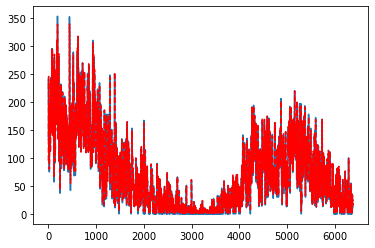

In [9]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

import matplotlib.pyplot as plt

plt.figure
plt.plot(y_test)
plt.plot(pred,'r--')